# Modeling
### plan
> 1) 기상청 데이터를 활용해서 외부 날씨 예측 => 시계열
    * 이때, test데이터에는 30분 단위 값도 있고, 기상청 데이터는 1시간 단위이므로 기상청 데이터에 30분단위도 추가필요
    * 같은시간대의 데이터만 가져와서 시간대별로 예측하는 방식
> 2) 외부 날씨로 공장내부 온도,습도,코일온도,이슬점온도 등을 예측 => 회귀

> 3) 공장내부 온도,습도,코일온도,이슬점온도 등의 정보로 결로현상 예측 => 분류, 로지스틱회귀


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from itertools import cycle
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [3]:
# 한글깨짐 문제
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [15]:
plant1_train=pd.read_csv('./data/plant1_train.csv',index_col=[0],parse_dates=['plant1_train.mea_ddhr'])
plant2_train=pd.read_csv('./data/plant2_train.csv',index_col=[0],parse_dates=['plant2_train.mea_ddhr'])
plant_test=pd.read_csv('./data/plant_test.csv',index_col=[0],parse_dates=['plant_test.mea_ddhr'])

# 당진
dangjin_humid=pd.read_csv('./data/dangjin_humid.csv',index_col=None)
dangjin_rain=pd.read_csv('./data/dangjin_rain.csv',index_col=None)
dangjin_tem=pd.read_csv('./data/dangjin_tem.csv',index_col=None)

# 신평
shinpyung_humid=pd.read_csv('./data/shinpyung_humid.csv',index_col=None)
shinpyung_rain=pd.read_csv('./data/shinpyung_rain.csv',index_col=None)
shinpyung_tem=pd.read_csv('./data/shinpyung_tem.csv',index_col=None)

# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])

# test데이터셋과 동일하게 train 데이터 전처리
plant_train=pd.read_csv('./data/plant_train.csv',index_col=[0])

In [7]:
# 서산
seosan=pd.read_csv('./data/asos_서산_시간별.csv',index_col=None,parse_dates=['일시'])

### 컬럼명 전처리

In [16]:
# 날씨 컬럼명 정리
dangjin = [dangjin_tem, dangjin_rain, dangjin_humid]
#seosan=[seosan]

for d in dangjin:
    d.columns = [col.split('.')[1] for col in d.columns]    
    d.rename(columns={'tm':'datetime'}, inplace=True)    

In [17]:
# 공장 컬럼명 정리
plant = [plant1_train, plant2_train, plant_test]

for p in plant:
    p.columns = [col.split('.')[1] for col in p.columns]    
    p.rename(columns={'mea_ddhr':'datetime'}, inplace=True)    

### 기온, 습도, 이슬점온도 컬럼 분리

In [8]:
# 30분단위 추가 전
seosan_hum=seosan[['일시','습도(%)']]
seosan_hum.columns=['일시','습도']
seosan_dew=seosan[['일시','이슬점온도(°C)']]
seosan_dew.columns=['일시','이슬점온도']
seosan_tem=seosan[['일시','기온(°C)']]
seosan_tem.columns=['일시','기온']
#seosan_tem=seosan_tem.iloc[:26246]     # train 데이터 분리.

### 30분 단위 추가

In [9]:
index_30min=pd.date_range('2016-04-01 00:30:00', periods=35231, freq='H')
index_30min=index_30min.to_frame().rename(columns={0:'일시'})
seosan2=pd.concat([seosan,index_30min],ignore_index=True)
seosan2=seosan2.sort_values('일시').reset_index(drop=True)
seosan2.head()

,10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C),3시간신적설(cm),5cm 지중온도(°C),강수량 QC플래그,강수량(mm),기온 QC플래그,기온(°C),습도 QC플래그,습도(%),시정(10m),운형(운형약어),이슬점온도(°C),일사(MJ/m2),일시,일조 QC플래그,일조(hr),적설(cm),전운량(10분위),중하층운량(10분위),증기압(hPa),지면상태(지면상태코드),지면온도 QC플래그,지면온도(°C),지점,지점명,최저운고(100m ),풍속 QC플래그,풍속(m/s),풍향 QC플래그,풍향(16방위),해면기압 QC플래그,해면기압(hPa),현상번호(국내식),현지기압 QC플래그,현지기압(hPa)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8.8,0.0,41.0,2000.0,NaN,-3.7,NaN,2016-04-01 00:00:00,9.0,NaN,NaN,0.0,0.0,4.6,NaN,0.0,4.0,129.0,서산,NaN,0.0,1.5,0.0,50.0,0.0,1015.6,NaN,0.0,1012.1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.2,0.0,34.0,2000.0,NaN,-5.8,NaN,2016-04-01 01:00:00,9.0,NaN,NaN,NaN,NaN,4.0,NaN,0.0,3.4,129.0,서산,NaN,0.0,1.2,0.0,50.0,0.0,1015.2,NaN,0.0,1011.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.2,0.0,33.0,2000.0,NaN,-6.2,NaN,2016-04-01 02:00:00,9.0,NaN,NaN,NaN,NaN,3.8,NaN,0.0,3.3,129.0,서산,NaN,0.0,1.1,0.0,20.0,0.0,1014.8,NaN,0.0,1011.3


### 30분단위 추가 후  기온, 습도, 이슬점온도 분류

In [10]:
# 30분단위 추가 후  기온, 습도, 이슬점온도 분류
seosan_hum2=seosan2[['일시','습도(%)']]
seosan_hum2.columns=['일시','습도']
seosan_dew2=seosan2[['일시','이슬점온도(°C)']]
seosan_dew2.columns=['일시','이슬점온도']
seosan_tem2=seosan2[['일시','기온(°C)']]
seosan_tem2.columns=['일시','기온']
#seosan_tem=seosan_tem.iloc[:26246]     # train 데이터 분리.

In [11]:
seosan_tem2.head()

,일시,기온
0,2016-04-01 00:00:00,8.8
1,2016-04-01 00:30:00,NaN
2,2016-04-01 01:00:00,9.2
3,2016-04-01 01:30:00,NaN
4,2016-04-01 02:00:00,9.2


### 결측값 보간

In [12]:
seosan_tem2=seosan_tem2.interpolate()
seosan_hum2=seosan_hum2.interpolate()
seosan_dew2=seosan_dew2.interpolate()
print('기온 결측치:',seosan_tem2.isnull().sum())
print('습도 결측치:',seosan_hum2.isnull().sum())
print('이슬점온도 결측치:',seosan_dew2.isnull().sum())

기온 결측치: 일시    0
기온    0
dtype: int64
습도 결측치: 일시    0
습도    0
dtype: int64
이슬점온도 결측치: 일시       0
이슬점온도    0
dtype: int64


In [13]:
seosan_tem2.head()

,일시,기온
0,2016-04-01 00:00:00,8.8
1,2016-04-01 00:30:00,9.0
2,2016-04-01 01:00:00,9.2
3,2016-04-01 01:30:00,9.2
4,2016-04-01 02:00:00,9.2


------------------------------------------------------------------------------------------------------------------------------------------------
## ARIMA 모델

#### 1) 500일 이전시점 train & predict 
* 시간대 4:30 인것만 500일 가져오기
* 2019-04-01 04:30 이전 500일 데이터로 2019-04-02 04:30 과, 2019-04-03 04:30 값 예측

In [14]:
# 4시반 데이터만 일자별로 가져오기
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)
hour4_30

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
1463,2020-04-03 04:30:00,1.55
1464,2020-04-04 04:30:00,6.05
1465,2020-04-05 04:30:00,4.10
1466,2020-04-06 04:30:00,-1.30


In [18]:
# 2019-04-01 4:30 포함해서 이전 500일
### 2019-04-01 04:30 이전 500일 데이터로 두시점 이후 예측 (24h, 48h)
day_500=hour4_30[1096-(500):1096].set_index('일시')
day_500

,기온
일시,
2017-11-18 04:30:00,1.30
2017-11-19 04:30:00,-2.05
2017-11-20 04:30:00,0.05
2017-11-21 04:30:00,-3.30
2017-11-22 04:30:00,2.00
...,...
2019-03-28 04:30:00,4.95
2019-03-29 04:30:00,5.75
2019-03-30 04:30:00,4.60


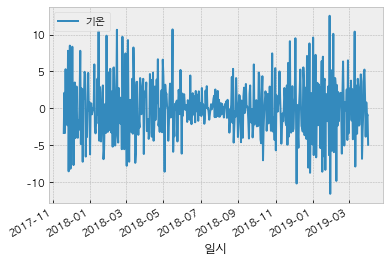

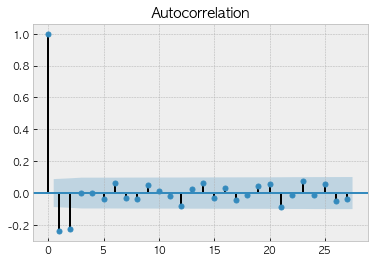

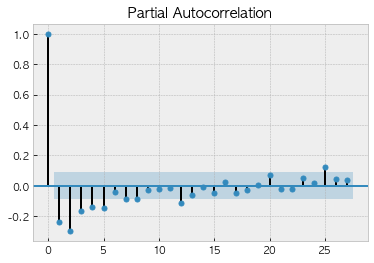

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_1=day_500.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

In [44]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pyramid.arima import auto_arima
stepwise_model = auto_arima(day_500, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2623.654, BIC=2644.595, Fit time=2.208 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=3050.951, BIC=3059.328, Fit time=0.046 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2859.719, BIC=2876.472, Fit time=0.780 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2656.998, BIC=2673.751, Fit time=1.248 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2623.629, BIC=2648.758, Fit time=1.770 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=2757.548, BIC=2778.489, Fit time=0.893 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2621.507, BIC=2650.825, Fit time=7.035 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2652.533, BIC=2677.663, Fit time=5.300 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2616.998, BIC=2650.504, Fit time=8.002 seconds
Fit ARIMA: order=(2, 1, 0) s

In [45]:
stepwise_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  500
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood               -1300.499
Date:                                 Wed, 03 Jun 2020   AIC                           2616.998
Time:                                         20:55:43   BIC                           2650.504
Sample:                                              0   HQIC                          2630.160
                                                 - 500                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0044      0.005     -0.834      0.405      -0.015       0.006
ar.L1          0.3293      0.059      5.554      0.000       0.213       0.446
ar.L2         -0.1287      0.049     -2.648      0.008      -0.224      -0.033
ma.L1         -0.7917      0.046    -17.041      0.000      -0.883      -0.701
ar.S.L12      -0.9965      0.026    -38.229      0.000      -1.048      -0.945
ma.S.L12      -0.0170     20.210     -0.001      0.999     -39.628      39.594
ma.S.L24      -0.9829     19.865     -0.049      0.961     -39.917      37.952
sigma2        10.9253    220.717      0.049      0.961    -421.672     443.523
===================================================================================
Ljung-Box (Q):                       35.87   Jarque-Bera (JB):                 6.40
Prob(Q):                              0.66   Prob(JB):                         0.04
Heteroskedasticity (H):               1.05   Skew:                             0.27
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(day_500, order=(2,1,1))
model_fit = model.fit(trend='nc',full_output=True, disp=1)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D.기온   No. Observations:                  499
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1311.164
Method:                       css-mle   S.D. of innovations              3.347
Date:                Wed, 03 Jun 2020   AIC                           2630.328
Time:                        20:55:58   BIC                           2647.179
Sample:                    11-19-2017   HQIC                          2636.941
                         - 04-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.기온     0.3543      0.060      5.904      0.000       0.237       0.472
ar.L2.D.기온    -0.1194      0.051     -2.321      0.020      -0.220      -0.019
ma.L1.D.기온    -0.7969      0.043    -18.426      0.0

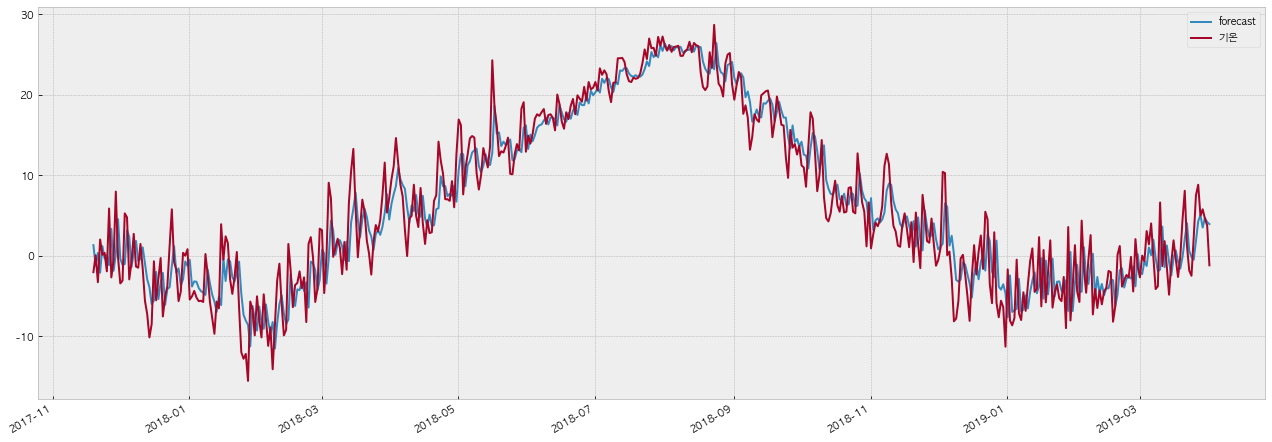

In [47]:
fig,ax=plt.subplots()
fig.set_size_inches(22,8)
fig=model_fit.plot_predict(ax=ax)
plt.show()

In [79]:
# 예측값, stderr, upper bound, lower bound 
fore = model_fit.forecast(steps=1)
print(fore)

(array([1.2271246]), array([3.34666398]), array([[-5.33221626,  7.78646546]]))


In [44]:
fore[0].tolist()

[1.3386737534988942]

In [56]:
pd.Series(fore[0])

0    1.338674
dtype: float64

In [43]:
#fore[0]
arr=np.array([100])
np.append(fore[0],arr)

array([  1.33867375, 100.        ])

In [49]:
# 2019-04-02 , 2019-04-03 04:30 데이터 예측값과 실제값 비교
## 2019-04-02(04:30) ===> -2.45
## 2019-04-03(04:30) ===> -1.30
hour4_30[1096-(500):1098]

,일시,기온
596,2017-11-18 04:30:00,1.30
597,2017-11-19 04:30:00,-2.05
598,2017-11-20 04:30:00,0.05
599,2017-11-21 04:30:00,-3.30
600,2017-11-22 04:30:00,2.00
...,...,...
1093,2019-03-30 04:30:00,4.60
1094,2019-03-31 04:30:00,3.75
1095,2019-04-01 04:30:00,-1.20
1096,2019-04-02 04:30:00,-2.45


#### 2) shifting해서 학습하고 하루하루씩 예측
* 1 ~ 500으로 학습하고 501번째 예측한값이랑 2~501으로 학습하고 502번째 예측한값이랑.. 해서
예측값들과 실제값간의 그래프 그리기

In [61]:
# series에 array 를 append
ser=pd.Series()
for i in range(5):
    result=pd.Series(np.array([i*2]))
    np.append(ser,result)
    print(result)

0    0
dtype: int64
0    2
dtype: int64
0    4
dtype: int64
0    6
dtype: int64
0    8
dtype: int64


In [95]:
# array 와 array를 append할경우.
arr=np.array([])
for i in range(5):
    result=np.array([i*2])
    np.append(arr,result)
    print(result)

[0]
[2]
[4]
[6]
[8]


In [72]:
# list에 array를 append할경우
list=[]
for i in range(5):
   # result=np.array([i*2]).tolist()
    result=np.array([i*2])
    list.append(result)
print(list)

[array([0]), array([2]), array([4]), array([6]), array([8])]


In [73]:
# list에 list를 append할경우
list=[]
for i in range(5):
    result=np.array([i*2]).tolist()
    list.append(result)
print(list)

[[0], [2], [4], [6], [8]]


In [141]:
# train = 1000
# test= 1468-1000=468
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)
hour4_30

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
1463,2020-04-03 04:30:00,1.55
1464,2020-04-04 04:30:00,6.05
1465,2020-04-05 04:30:00,4.10
1466,2020-04-06 04:30:00,-1.30


In [ ]:
start = len(train)   # 950
end = len(train) + len(test) - 1    # 999
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['기온'].plot(legend = True)
plt.show()

#### 예시 테스트용 코드
* list에 array값을 append한결과
    * [array([23.95573504]), array([22.79908278]), array([23.09846874]),....

In [23]:
list(range(0,5))

[0, 1, 2, 3, 4]

In [34]:
hour4_30.shape[0]

1468

In [27]:
hour4_30.shape[0]-500

968

In [ ]:
# period=500
# for i in range(0, hour4_30.shape[0]-500):   # i = 0~1467 (총1468이지만 그전까지 예측해야하므로)
#     train=hour4_30.iloc[ i: period+i].set_index('일시')  # train= 0~500, 1~501, 2~502 ...(1467-500)=967~1467
#     test=hour4_30.iloc[period+i+1]  # 501,502,503,,,,1468
#     model = ARIMA(train, order=(2,1,1))
#     model_fit = model.fit(trend='nc',full_output=True, disp=1)

In [99]:
hour4_30[:100].shape[0]-20

80

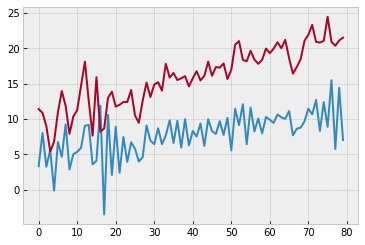

[11.4, 10.850000000000001, 8.95, 5.4, 6.8, 10.95, 13.95, 11.85, 7.8999999999999995, 10.35, 11.25, 14.7, 18.1, 12.55, 7.65, 15.9, 8.2, 8.65, 13.0, 13.85, 11.75, 12.0, 12.4, 12.399999999999999, 14.1, 10.5, 9.45, 12.6, 15.15, 13.100000000000001, 14.85, 15.2, 14.0, 17.8, 15.850000000000001, 16.5, 15.5, 15.75, 16.05, 14.6, 15.75, 16.75, 15.45, 16.1, 18.1, 16.1, 17.35, 17.25, 17.85, 15.65, 16.950000000000003, 20.5, 21.0, 18.35, 18.15, 19.65, 18.4, 17.799999999999997, 18.35, 19.95, 19.3, 19.95, 20.85, 20.0, 21.200000000000003, 18.6, 16.4, 17.35, 18.45, 21.05, 21.9, 23.3, 20.9, 20.799999999999997, 21.049999999999997, 24.45, 20.9, 20.35, 21.1, 21.5]


In [134]:
############################################################################## 테스트용
from statsmodels.tsa.arima_model import ARIMA
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)

list=[]
test_list=[]
period=20
for i in range(0, hour4_30[:100].shape[0]-20):   # i = 0~968 (총1468이지만 그전까지 예측해야하므로)
    train=hour4_30[:100].iloc[ i: period+i].set_index('일시')  # train= 0~500, 1~501, 2~502 ...(1467-500)=967~1467
    test=hour4_30[:100].iloc[period+i]['기온']  # 501,502,503,,,,1468
    model = ARIMA(train, order=(0,0,1))
    model_fit = model.fit(trend='nc',full_output=True, disp=1)
    fore = model_fit.forecast(steps=1)
    list.append(fore[0])
    test_list.append(test)
    
plt.plot(list)
plt.plot(test_list)
plt.show()

print(test_list)

In [ ]:
############################################## 실제 돌릴 코드
from statsmodels.tsa.arima_model import ARIMA
# i = 500,501,502,,,,1468
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)

list=[]
test_list=[]
period=500
for i in range(0, hour4_30.shape[0]-500):   # i = 0~968 (총1468이지만 그전까지 예측해야하므로)
    train=hour4_30.iloc[ i: period+i].set_index('일시')  # train= 0~500, 1~501, 2~502 ...(1467-500)=967~1467
    test=hour4_30.iloc[period+i]['기온']  # 501,502,503,,,,1468
    model = ARIMA(train, order=(2,1,1))
    model_fit = model.fit(trend='nc',full_output=True, disp=1)
    fore = model_fit.forecast(steps=1)
    
    list.append(fore[0])    # 예측값
    test_list.append(test)    # 실제값

# prediction plot 과 실제값(test) plot 그리기.
plt.plot(list)
plt.plot(test_list)
plt.show()
print(result)


#### 실제 돌릴 코드

In [136]:
# i = 500,501,502,,,,1468
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)

arr=np.array([])
for i in range(500, hour4_30.shape[0]):    # 500~1468
    train=hour4_30.iloc[ (i-500) : i ].set_index('일시')
    model = ARIMA(train, order=(2,1,1))
    model_fit = model.fit(trend='nc',full_output=True, disp=1)
    fore = model_fit.forecast(steps=1)   
    
    np.append(arr,fore[0])
    print(fore[0])

[23.95573506]
[22.79908282]
[23.09846889]
[23.63865057]
[23.20518575]
[22.48288647]
[22.60716117]
[22.92923989]
[23.26863666]
[23.36809597]
[24.50280119]
[25.44544404]
[22.84624499]
[21.63532951]
[20.62641672]
[19.98705367]
[20.11003951]
[19.2032883]
[18.19201728]
[18.37651794]
[17.99785609]
[17.68326415]
[18.60234072]
[18.72467189]
[19.16538713]
[18.32072]
[18.79365362]
[18.76170895]
[18.35067382]
[18.71992528]
[17.28132861]
[16.16411052]
[15.30311971]
[17.11109756]
[16.9597592]
[17.71161515]
[16.11421737]
[18.22318536]
[17.02614285]
[14.81228538]
[14.64035887]
[15.77365644]
[18.56554596]
[18.23427512]
[17.88430748]
[17.09143361]
[18.37902287]
[13.61079099]
[13.53477221]
[15.21394279]
[15.38275827]
[14.81564678]
[13.21924768]
[13.03534939]
[14.3789878]
[14.06878913]
[15.31139381]
[15.76014816]
[16.23962989]
[16.17215019]
[14.19617361]
[10.46815151]
[10.12380628]
[11.00266266]
[12.8306558]
[10.43989318]
[13.73033195]
[12.08511355]
[11.00984827]
[11.5241313]
[11.30816397]
[11.08833851]


KeyboardInterrupt: 

In [69]:
hour4_30.shape[0]

1468

In [ ]:
hour4_30.iloc[(1468-500):1468]

In [156]:
# test값은 iloc[500], 501, 502,,,,1468
hour4_30.iloc[500]

일시    2017-08-14T04:30:00.000000000
기온                            21.65
Name: 500, dtype: object

In [66]:
hour4_30.iloc[0:500]

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
495,2017-08-09 04:30:00,23.45
496,2017-08-10 04:30:00,24.05
497,2017-08-11 04:30:00,22.50
498,2017-08-12 04:30:00,23.70


In [67]:
hour4_30.iloc[1:501]

,일시,기온
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
5,2016-04-06 04:30:00,3.10
...,...,...
496,2017-08-10 04:30:00,24.05
497,2017-08-11 04:30:00,22.50
498,2017-08-12 04:30:00,23.70
499,2017-08-13 04:30:00,24.20


In [55]:
# 4시반 데이터만 일자별로 가져오기
hour4_30=seosan_tem2[(seosan_tem2['일시'].apply(lambda x:x.hour)==4)]
hour4_30=hour4_30[(hour4_30['일시'].apply(lambda x:x.minute)==30)].reset_index(drop=True)
hour4_30

,일시,기온
0,2016-04-01 04:30:00,4.20
1,2016-04-02 04:30:00,4.60
2,2016-04-03 04:30:00,8.90
3,2016-04-04 04:30:00,7.15
4,2016-04-05 04:30:00,1.50
...,...,...
1463,2020-04-03 04:30:00,1.55
1464,2020-04-04 04:30:00,6.05
1465,2020-04-05 04:30:00,4.10
1466,2020-04-06 04:30:00,-1.30


In [ ]:
# Split data into train / test sets 
train = seosan_tem2[:1000].iloc[:len(seosan_tem2[:1000])-50] 
test = seosan_tem2[:1000].iloc[len(seosan_tem2[:1000])-50:]  
  
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train['기온'][:1000], order=(2,1,1))
result = model.fit() 
result.summary() 

In [ ]:
start = len(train)   # 950
end = len(train) + len(test) - 1    # 999
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['기온'].plot(legend = True)
plt.show()